### **Loading Data**

In [1]:
import os 
os.chdir("..")
os.listdir()

['run',
 'etc',
 'bin',
 'media',
 'home',
 'srv',
 'var',
 'lib',
 'sbin',
 'opt',
 'tmp',
 'usr',
 'dev',
 'mnt',
 'lib64',
 'boot',
 'root',
 'proc',
 'sys',
 'MSFT-1.csv',
 'microsoft_stock_rnn.h4',
 '.dockerenv',
 'tools',
 'datalab',
 'content',
 'python-apt',
 'lib32',
 'NGC-DL-CONTAINER-LICENSE']

In [493]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("MSFT-1.csv", index_col="Date")
print("\n \033[1;3m First five rows of dataset :\033[0m\n ")
print(data.head())

print("\n\n\n\033[1;3m Shape of the given data is :\033[0m \n")
print(data.shape)

print("\n\n\n\033[1;3m Statistics identifying data types and Null values in the given dataset :\033[0m \n")
print(data.info())


  First five rows of dataset :
 
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
11/7/2016   59.779999  60.520000  59.779999  60.419998  55.902321  31664800
11/8/2016   60.549999  60.779999  60.150002  60.470001  55.948589  22935400
11/9/2016   60.000000  60.590000  59.200001  60.169998  55.671009  49632500
11/10/2016  60.480000  60.490002  57.630001  58.700001  54.310928  57822400
11/11/2016  58.230000  59.119999  58.009998  59.020000  54.607002  38767800



 Shape of the given data is : 

(1259, 6)



 Statistics identifying data types and Null values in the given dataset : 

<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 11/7/2016 to 11/5/2021
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   floa

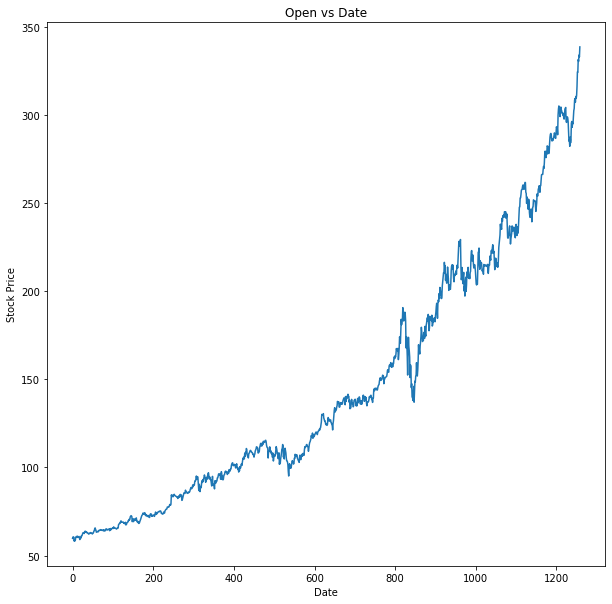

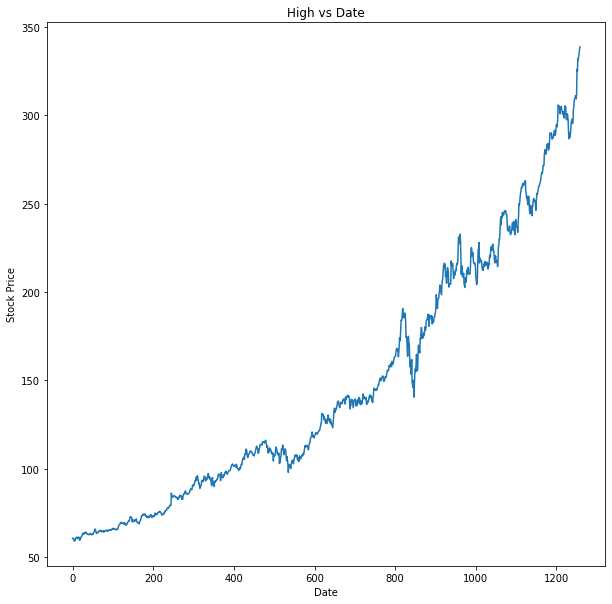

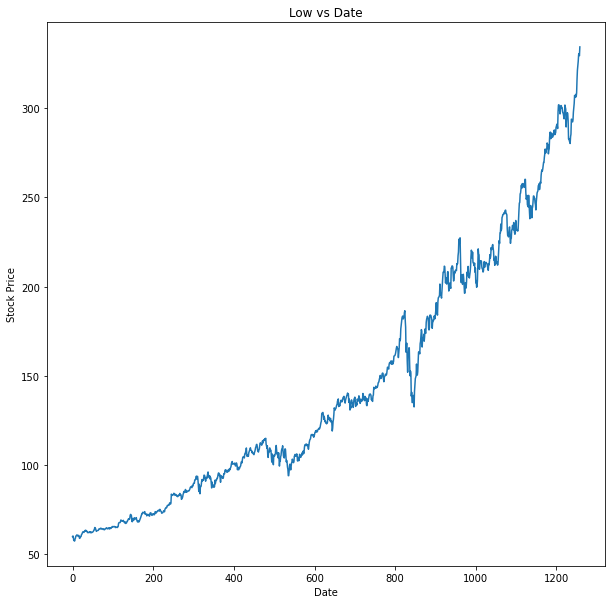

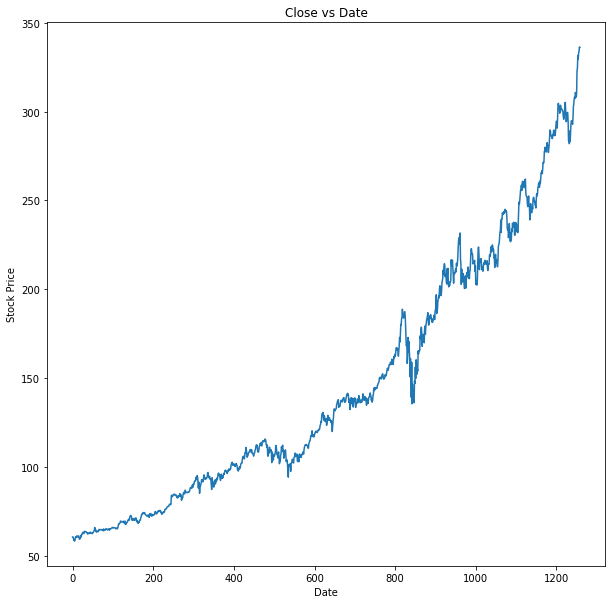

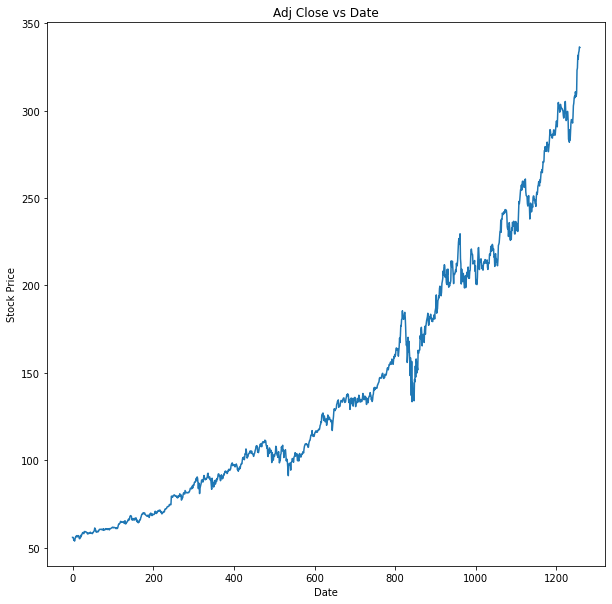

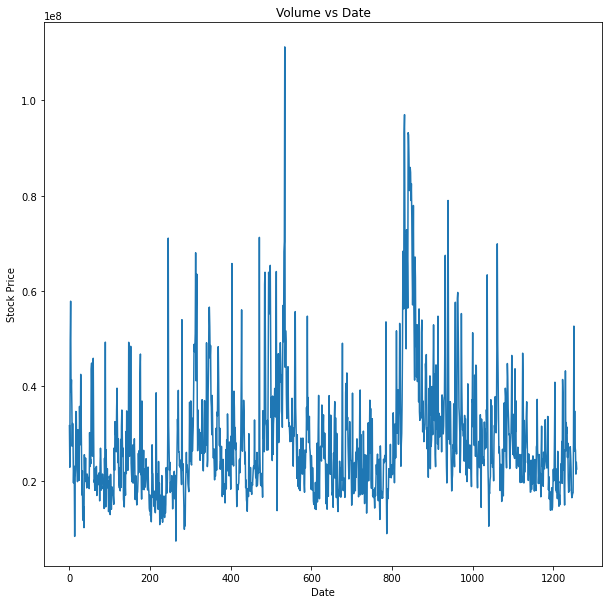

In [418]:
list = data.columns
for i in list:
  data_temp1 = data.reset_index()[i]
  plt.figure(figsize=(10,10))
  plt.plot(data_temp1)
  plt.title('{} vs Date'.format(i))
  plt.xlabel('Date')
  plt.ylabel('Stock Price')
  plt.show()


### Data Pre-processing

In [563]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def data_preprocessing(data, step_in, step_out):
    train, test = train_test_split(data)
    x_train, x_test = windowing_data(train, step_in, step_out)
    y_train, y_test = windowing_data(test, step_in, step_out)
    return x_train, x_test, y_train, y_test

def train_test_split(dataset):
    train_data_size = int(len(dataset) * 0.9)
    train_data, test_data = dataset[0:train_data_size, :], dataset[train_data_size:len(dataset), :]
    return train_data, test_data

def windowing_data(data, days_used_in_prediction, days_to_be_predicted):
    x = []
    y = []
    for i in range(len(data)):
        end_i = i + days_used_in_prediction
        out_i = end_i + days_to_be_predicted
        if out_i > len(data):
            break
        x_temp,y_temp = data[i:end_i, :], data[end_i:out_i, :]
        x.append(x_temp)
        y.append(y_temp)
    return np.array(x), np.array(y)

In [564]:
scaler = MinMaxScaler(feature_range=(0,1))
values = data.values.reshape(-1,6)
values = scaler.fit_transform(values)
x_train, y_train, x_test, y_test = data_preprocessing(values, 30, 15)

In [565]:
x_train.shape

(1089, 30, 6)

In [567]:
x_test.shape

(82, 30, 6)

In [424]:
y_train.shape

(963, 15, 6)

In [425]:
y_test.shape

(208, 15, 6)

### **Modelling data**

In [426]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense , TimeDistributed , LSTM , RepeatVector
from keras.models import Model

**Creating loss function to measure mean square error in last time step**

In [569]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [666]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(30, 6)))
model.add(RepeatVector(15))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(6)))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[last_time_step_mse])

  
history = model.fit(x_train, y_train, epochs=25
                    , validation_split=0.1, batch_size = 32)

Epoch 1/25
31/31 [==============================] - 9s 161ms/step - loss: 0.0382 - last_time_step_mse: 0.0331 - val_loss: 0.0827 - val_last_time_step_mse: 0.0204
Epoch 2/25
31/31 [==============================] - 4s 122ms/step - loss: 0.0119 - last_time_step_mse: 0.0057 - val_loss: 0.0209 - val_last_time_step_mse: 0.0093
Epoch 3/25
31/31 [==============================] - 4s 119ms/step - loss: 0.0054 - last_time_step_mse: 0.0040 - val_loss: 0.0202 - val_last_time_step_mse: 0.0255
Epoch 4/25
31/31 [==============================] - 4s 116ms/step - loss: 0.0042 - last_time_step_mse: 0.0039 - val_loss: 0.0114 - val_last_time_step_mse: 0.0358
Epoch 5/25
31/31 [==============================] - 4s 117ms/step - loss: 0.0038 - last_time_step_mse: 0.0036 - val_loss: 0.0094 - val_last_time_step_mse: 0.0094
Epoch 6/25
31/31 [==============================] - 4s 120ms/step - loss: 0.0032 - last_time_step_mse: 0.0031 - val_loss: 0.0067 - val_last_time_step_mse: 0.0060
Epoch 7/25
31/31 [==========

In [667]:
model.summary()

Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_187 (LSTM)             (None, 50)                11400     
                                                                 
 repeat_vector_58 (RepeatVec  (None, 15, 50)           0         
 tor)                                                            
                                                                 
 lstm_188 (LSTM)             (None, 15, 100)           60400     
                                                                 
 lstm_189 (LSTM)             (None, 15, 200)           240800    
                                                                 
 lstm_190 (LSTM)             (None, 15, 200)           320800    
                                                                 
 time_distributed_73 (TimeDi  (None, 15, 6)            1206      
 stributed)                                          

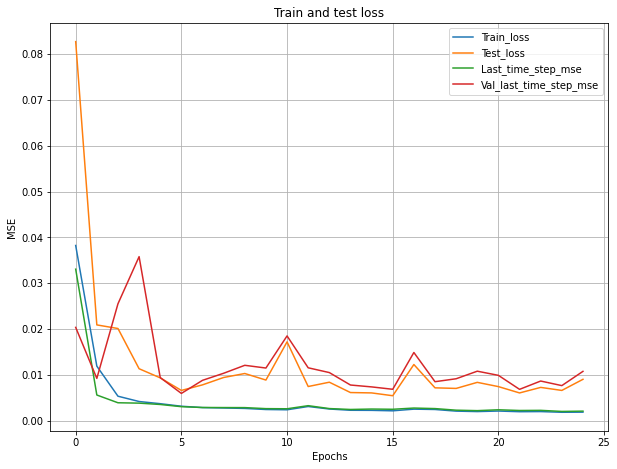

In [668]:
fig, ax = plt.subplots(figsize=(10, 7.5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['last_time_step_mse'])
plt.plot(history.history['val_last_time_step_mse'])
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['Train_loss','Test_loss','Last_time_step_mse' ,'Val_last_time_step_mse' ])
plt.grid()
plt.title("Train and test loss");

In [669]:
y_pred_1 = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred_1[0,:,:].reshape(-1,6))

3/3 [==============================] - 1s 27ms/step


In [670]:
predictions_df = pd.DataFrame({'Open': y_pred[:,0], 'High': y_pred[:,1], 
                                   'Low': y_pred[:,2], 'Close': y_pred[:,3], 
                                    'Volume': y_pred[:,5]})
predictions_df

,Open,High,Low,Close,Volume
0,210.619843,217.754730,214.012085,210.477707,32216208.0
1,216.237198,222.336166,216.873032,217.805084,36267612.0
2,213.783508,219.705185,212.112045,215.828033,36095516.0
3,211.836105,217.140320,208.797516,214.149933,35738532.0
4,209.904984,214.571213,206.213638,212.293594,35086836.0
5,209.065964,212.956726,205.024551,211.303619,34566908.0
6,208.740967,211.853973,204.470566,210.759293,34166476.0
7,208.647202,211.057526,204.258331,210.465179,33869148.0
8,208.642914,210.445602,204.232117,210.308044,33657036.0
9,208.669327,209.952728,204.305359,210.222748,33513512.0


In [671]:
str = "\033[1;3mStatistics of predicted data\033[0m"
x = str.center(75)
print(x)
predictions_df.describe()

                   Statistics of predicted data                  


,Open,High,Low,Close,Volume
count,15.000000,15.000000,15.000000,15.000000,15.0
mean,210.000198,212.829041,206.914719,211.605362,34130732.0
std,2.274811,4.458830,4.107754,2.414737,1178946.5
min,208.642914,208.412506,204.232117,210.015640,32216208.0
25%,208.719727,209.364891,204.447502,210.150757,33352657.0
50%,208.804581,211.057526,204.817612,210.465179,33657036.0
75%,210.262413,215.855766,207.505577,211.798607,34826872.0
max,216.237198,222.336166,216.873032,217.805084,36267612.0


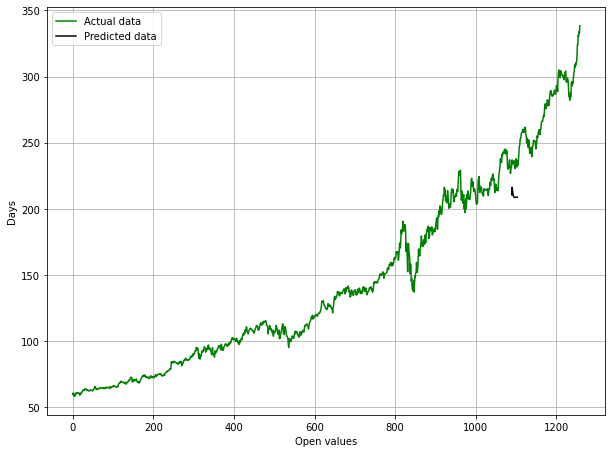

In [672]:
fig, ax = plt.subplots(figsize=(10, 7.5))
plt_data = data["Open"].values.reshape(-1,1)
temp_plt_data_2 = predictions_df["Open"].values.reshape(-1,1)
plt.plot(plt_data , color = "green")
plt.plot(range(x_train.shape[0],x_train.shape[0]+len(predictions_df["Open"])),temp_plt_data_2 , color="black")
plt.grid()
plt.xlabel("Open values")
plt.ylabel("Days")
plt.legend(["Actual data" , "Predicted data"])